In [146]:
import pickle
import numpy as np

with open('../F1F4_ids_rest_nback_3.bin', 'rb') as f:
    F1F4_ids_rest_nback = pickle.load(f)
    
for key in F1F4_ids_rest_nback:
    print(key)
    
F1_train_ids = F1F4_ids_rest_nback['F1_train_ids']
F4_train_ids = F1F4_ids_rest_nback['F4_train_ids']
F1_test_ids = F1F4_ids_rest_nback['F1_test_ids']
F4_test_ids = F1F4_ids_rest_nback['F4_test_ids']

print(F1_train_ids[0])

F1_train_ids
F4_train_ids
F1_test_ids
F4_test_ids
[859 888]


In [147]:
def loadTimeseries(_id, _dir):
    ts = None
    with open('{:s}/{:d}.bin'.format(_dir, _id), 'rb') as f:
        ts = pickle.load(f)
    return ts

F1_train_rest = [loadTimeseries(ids[0], '../rest_fmri_power264/timeseries') for ids in F1_train_ids]
F4_train_rest = [loadTimeseries(ids[0], '../rest_fmri_power264/timeseries') for ids in F4_train_ids]
F1_test_rest = [loadTimeseries(ids[0], '../rest_fmri_power264/timeseries') for ids in F1_test_ids]
F4_test_rest = [loadTimeseries(ids[0], '../rest_fmri_power264/timeseries') for ids in F4_test_ids]

F1_train_nback = [loadTimeseries(ids[1], '../nback_fmri_power264/timeseries') for ids in F1_train_ids]
F4_train_nback = [loadTimeseries(ids[1], '../nback_fmri_power264/timeseries') for ids in F4_train_ids]
F1_test_nback = [loadTimeseries(ids[1], '../nback_fmri_power264/timeseries') for ids in F1_test_ids]
F4_test_nback = [loadTimeseries(ids[1], '../nback_fmri_power264/timeseries') for ids in F4_test_ids]

print(len(F1_train_rest))
print(len(F4_train_rest))
print(len(F1_test_rest))
print(len(F4_test_rest))

print(len(F1_train_nback))
print(len(F4_train_nback))
print(len(F1_test_nback))
print(len(F4_test_nback))

74
93
24
30
74
93
24
30


In [148]:
# Normalize all datasets

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])

normalizeSubjects(F1_train_rest)
normalizeSubjects(F4_train_rest)
normalizeSubjects(F1_test_rest)
normalizeSubjects(F4_test_rest)

normalizeSubjects(F1_train_nback)
normalizeSubjects(F4_train_nback)
normalizeSubjects(F1_test_nback)
normalizeSubjects(F4_test_nback)

print('Normalization complete')

Normalization complete


In [149]:
# Labels

y_F1F4_train_rest = np.hstack([np.zeros([len(F1_train_rest)]), np.ones([len(F4_train_rest)])])
y_F1F4_test_rest = np.hstack([np.zeros([len(F1_test_rest)]), np.ones([len(F4_test_rest)])])

# Training and test sets

F1F4_train_rest = F1_train_rest + F4_train_rest
F1F4_test_rest = F1_test_rest + F4_test_rest
F1F4_train_nback = F1_train_nback + F4_train_nback
F1F4_test_nback = F1_test_nback + F4_test_nback

# Pearson matrices

F1F4_train_rest_cor = [subj@subj.T for subj in F1F4_train_rest]
F1F4_test_rest_cor = [subj@subj.T for subj in F1F4_test_rest]
F1F4_train_nback_cor = [subj@subj.T for subj in F1F4_train_nback]
F1F4_test_nback_cor = [subj@subj.T for subj in F1F4_test_nback]

print('Pearson complete')

import torch
import torch.nn as nn
import torch.nn.functional as F

import random

F1F4_train_rest_cor_torch = [torch.from_numpy(subj.flatten()).float() for subj in F1F4_train_rest_cor]
F1F4_test_rest_cor_torch = [torch.from_numpy(subj.flatten()).float() for subj in F1F4_test_rest_cor]
F1F4_train_nback_cor_torch = [torch.from_numpy(subj.flatten()).float() for subj in F1F4_train_nback_cor]
F1F4_test_nback_cor_torch = [torch.from_numpy(subj.flatten()).float() for subj in F1F4_test_nback_cor]

print('Torch complete')

Pearson complete
Torch complete


In [165]:
from sklearn.linear_model import LogisticRegression

X_F1F4_train_rest_nback_cor = np.zeros([len(F1F4_train_rest), 264*264])
X_F1F4_test_rest_nback_cor = np.zeros([len(F1F4_test_rest), 264*264])

for i in range(len(F1F4_train_rest)):
    #X_F1F4_train_rest_nback_cor[i,:] = np.hstack([F1F4_train_rest_cor[i].flatten(), F1F4_train_nback_cor[i].flatten()])
    X_F1F4_train_rest_nback_cor[i,:] = F1F4_train_rest_cor[i].flatten()
    
for i in range(len(F1F4_test_rest)):
    #X_F1F4_test_rest_nback_cor[i,:] = np.hstack([F1F4_test_rest_cor[i].flatten(), F1F4_test_nback_cor[i].flatten()])
    X_F1F4_test_rest_nback_cor[i,:] = F1F4_test_rest_cor[i].flatten()
    
print('Complete')

Complete


In [157]:
# Logistic regression

clf = LogisticRegression(max_iter=500).fit(X_F1F4_train_rest_nback_cor, y_F1F4_train_rest)
print('Finished')

Finished


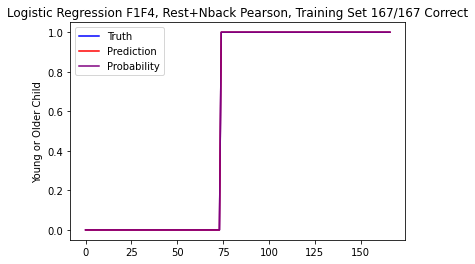

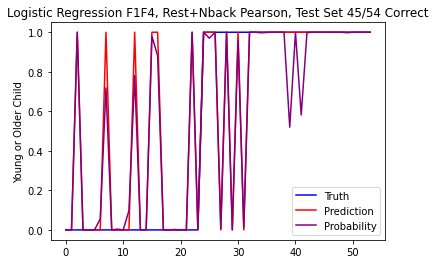

In [158]:
# Display results

import matplotlib.pyplot as plt

def show_results(y_true, y_predict, y_prob=None, title="", label="Young or Older Child"):
    nCorrect = 0
    for i in range(len(y_true)):
        if y_true[i] == y_predict[i]:
            nCorrect += 1

    fig, ax = plt.subplots()
    
    ax.plot(y_true, color='blue', label='Truth')
    ax.plot(y_predict, color='red', label='Prediction')
    
    if y_prob is not None:
        ax.plot(y_prob[:,1], color='purple', label='Probability')
        
    ax.set_title(title + ' {:d}/{:d} Correct'.format(nCorrect, len(y_true)))
    ax.set_ylabel(label)
    ax.legend()

    plt.show()
    
y1 = clf.predict(X_F1F4_train_rest_nback_cor)
y1_prob = clf.predict_proba(X_F1F4_train_rest_nback_cor)
y1_test = clf.predict(X_F1F4_test_rest_nback_cor)
y1_test_prob = clf.predict_proba(X_F1F4_test_rest_nback_cor)

show_results(y_F1F4_train_rest, y1, y1_prob, 'Logistic Regression F1F4, Rest+Nback Pearson, Training Set')
show_results(y_F1F4_test_rest, y1_test, y1_test_prob, 'Logistic Regression F1F4, Rest+Nback Pearson, Test Set')

In [166]:
# RBF

from sklearn import svm

clf = svm.SVC(kernel='rbf', probability=True, C=100, gamma=5e-10)
clf.fit(X_F1F4_train_rest_nback_cor, y_F1F4_train_rest)

print('Complete')

Complete


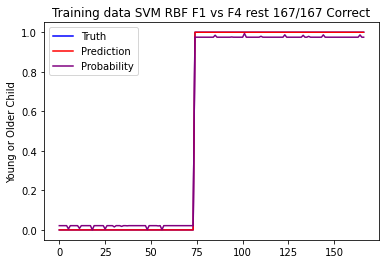

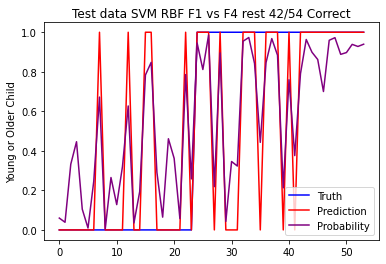

In [167]:
y1 = clf.predict(X_F1F4_train_rest_nback_cor)
y1_prob = clf.predict_proba(X_F1F4_train_rest_nback_cor)

show_results(y_F1F4_train_rest, y1, y1_prob, "Training data SVM RBF F1 vs F4 rest")

y1_test = clf.predict(X_F1F4_test_rest_nback_cor)
y1_test_prob = clf.predict_proba(X_F1F4_test_rest_nback_cor)

show_results(y_F1F4_test_rest, y1_test, y1_test_prob, "Test data SVM RBF F1 vs F4 rest")

In [181]:
class MLPSingle(nn.Module):
    def __init__(self):
        super(MLPSingle, self).__init__()
        self.fc1 = nn.Linear(264*264*2,100)
        self.fc2 = nn.Linear(100,2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class MLPDouble(nn.Module):
    def __init__(self):
        super(MLPDouble, self).__init__()
        self.fc1 = nn.Linear(2*264*264,100)
        self.fc2 = nn.Linear(100,2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

print('MLP Complete')

MLP Complete


In [182]:
mlpSingle = MLPSingle()
optimSingle = torch.optim.SGD(mlpSingle.parameters(), momentum=0.5, lr=5e-7)

print('Single complete')

Single complete


In [183]:
F1F4_train_rest_nback_cor_torch = []
F1F4_test_rest_nback_cor_torch = []

for i in range(len(F1F4_train_rest_cor_torch)):
    F1F4_train_rest_nback_cor_torch.append(torch.cat([F1F4_train_rest_cor_torch[i], F1F4_train_nback_cor_torch[i]]))
    
for i in range(len(F1F4_test_rest_cor_torch)):
    F1F4_test_rest_nback_cor_torch.append(torch.cat([F1F4_test_rest_cor_torch[i], F1F4_test_nback_cor_torch[i]]))
    
print(F1F4_train_rest_nback_cor_torch[0].shape)

torch.Size([139392])


In [184]:
N = len(F1F4_train_rest_cor_torch)-1
running = 0

for epoch in range(2000):
    # Choose subject
    idx = random.randint(0,N)
    subj = F1F4_train_rest_nback_cor_torch[idx]
    truth = round(y_F1F4_train_rest[idx])
    
    # Train
    optimSingle.zero_grad()
    label = mlpSingle(subj)
    loss = -label[truth] + torch.log(torch.sum(torch.exp(label)))
    loss.backward()
    
    # Backpropagate
    optimSingle.step()
    
    running += loss

    # print statistics
    if epoch % 100 == 0:    
        print('[epoch {:d}] loss: {:.3f}'.format(epoch, running/100))
        running = 0

print('Finished Training')

[epoch 0] loss: 0.067
[epoch 100] loss: 8.244
[epoch 200] loss: 3.326
[epoch 300] loss: 1.223
[epoch 400] loss: 1.808
[epoch 500] loss: 1.610
[epoch 600] loss: 0.974
[epoch 700] loss: 0.679
[epoch 800] loss: 0.007
[epoch 900] loss: 0.008
[epoch 1000] loss: 0.004
[epoch 1100] loss: 0.254
[epoch 1200] loss: 0.036
[epoch 1300] loss: 0.001
[epoch 1400] loss: 0.005
[epoch 1500] loss: 0.001
[epoch 1600] loss: 0.001
[epoch 1700] loss: 0.001
[epoch 1800] loss: 0.001
[epoch 1900] loss: 0.000
Finished Training


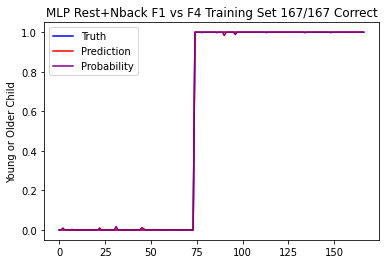

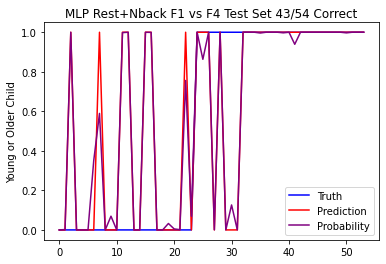

In [186]:
def getResults(mlp, subjects):
    y_predict = []
    y_prob = np.zeros([len(subjects),2])
    i = 0
    for subj in subjects:
        label = mlp(subj)
        idx = np.argmax(label.detach().numpy())
        y_predict.append(idx)
        p = torch.exp(label[idx])/torch.sum(torch.exp(label))
        if idx == 0:
            y_prob[i,1] = 1-p
        else:
            y_prob[i,1] = p
        i += 1
    return y_predict, y_prob

y1, y1p = getResults(mlpSingle, F1F4_train_rest_nback_cor_torch)
y2, y2p = getResults(mlpSingle, F1F4_test_rest_nback_cor_torch)

show_results(y_F1F4_train_rest, y1, y1p, "MLP Rest+Nback F1 vs F4 Training Set")
show_results(y_F1F4_test_rest, y2, y2p, "MLP Rest+Nback F1 vs F4 Test Set")